# CNN Exploration

In [1]:
# Imports
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# Reading in the data
mel_specs = pd.read_csv('../data/genre_mel_specs_clean.csv')

In [3]:
# First 5 rows for reference
mel_specs.head()

,0,1,2,3,4,5,6,7,8,9,...,84472,84473,84474,84475,84476,84477,84478,84479,labels,y
0,-24.185581,-27.340237,-27.214727,-23.694857,-10.349419,-11.817766,-19.678226,-26.396507,-25.827953,-30.779963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reggae,9
1,-34.482864,-29.062458,-34.239838,-41.848854,-38.884560,-46.740932,-41.780075,-42.449265,-37.310295,-38.989906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jazz,6
2,-31.571878,-38.357210,-37.502674,-32.508842,-22.891088,-28.224280,-33.885254,-35.000267,-35.614574,-36.325577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disco,4
3,-38.706380,-58.008110,-51.764940,-48.831757,-54.745650,-56.272590,-52.029984,-54.152860,-57.492695,-55.962650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jazz,6
4,-13.395082,-22.886148,-39.371693,-39.873516,-44.111927,-41.430832,-35.432774,-43.907005,-44.259710,-45.559254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disco,4


## Data Preprocessing

### Function to Get a Subset of the Genres

In [4]:
def get_genre_subset(data, genre_subset):
    
    # Getting the subset of the genres and resetting the index
    df = data.loc[data['labels'].isin(genre_subset)]
    df = df.reset_index().drop(columns=['index'])
    
    # Creating a new label dictionary
    new_label_dict = {}
    for i in range(len(genre_subset)):
        new_label_dict[genre_subset[i]] = i
    
    # Changing labels
    df['y'] = df['labels'].map(new_label_dict)

    return df

### Function to Preprocess the Features and Targets

In [21]:
def preprocess_mel_spec_data(data, genre_subset):
    
    # Getting a subset of the genres using our genre_subset function
    subset = get_genre_subset(data, genre_subset)
    
    # Dropping label columns to prepare our feature vector
    specs = subset.drop(columns=['labels', 'y'])
    
    # Reshaping the arrays to their original "image" form
    X = []
    for i in range(len(genre_subset)*100):
        X.append(np.array(specs.iloc[i]).reshape(128,660))
        
    # Converting list X to an array
    X = np.array(X)
    
    # Defining our targets
    y = subset.loc[subset['labels'].isin(genre_subset), 'y'].values
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)
    
    # Scaling our data to be between 0 and 1
    X_train /= -80
    X_test /= -80
    
    # Reshaping images to be 128 x 660 x 1
    X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
    X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)
    
    # One hot encoding our labels
    y_train = to_categorical(y_train, len(genre_subset))
    y_test = to_categorical(y_test, len(genre_subset))
    
    return X_train, X_test, y_train, y_test

In [6]:
# List of all the genres
genre_list = [ 
    'jazz',
    'reggae',
    'rock',
    'blues',
    'hiphop',
    'country',
    'metal',
    'classical',
    'disco',
    'pop'
]

In [199]:
# List of a subset of the genres
genre_subset = [
    'jazz',
    'reggae',
    'rock',
    'hiphop',
    'country',
    'metal',
    'classical'
]

In [20]:
# List of a subset of the genres
genre_subset_1 = [
    'jazz',
    'hiphop',
    'country',
    'metal',
    'classical',
    'disco',
    'pop'
]

In [22]:
# Using our function to get our features and targets
X_train, X_test, y_train, y_test = preprocess_mel_spec_data(mel_specs, genre_subset_1)

## CNN

In [23]:
np.random.seed(23456)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25))

# Adding an output layer
cnn_model.add(Dense(7, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=15)

Train on 560 samples, validate on 140 samples
Epoch 1/15
560/560 [==============================] - 9s 16ms/sample - loss: 1.8997 - accuracy: 0.2321 - val_loss: 1.6767 - val_accuracy: 0.4786
Epoch 2/15
560/560 [==============================] - 7s 13ms/sample - loss: 1.5573 - accuracy: 0.3821 - val_loss: 1.2844 - val_accuracy: 0.5143
Epoch 3/15
560/560 [==============================] - 8s 14ms/sample - loss: 1.2515 - accuracy: 0.5107 - val_loss: 1.0868 - val_accuracy: 0.6143
Epoch 4/15
560/560 [==============================] - 8s 13ms/sample - loss: 1.0465 - accuracy: 0.5946 - val_loss: 1.0620 - val_accuracy: 0.5786
Epoch 5/15
560/560 [==============================] - 8s 13ms/sample - loss: 0.8966 - accuracy: 0.6661 - val_loss: 0.8558 - val_accuracy: 0.7143
Epoch 6/15
560/560 [==============================] - 8s 13ms/sample - loss: 0.7738 - accuracy: 0.7518 - val_loss: 0.7752 - val_accuracy: 0.7143
Epoch 7/15
560/560 [==============================] - 8s 14ms/sample - loss: 0.7329 

In [24]:
# Checking the model summary
cnn_model.summary()

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 658, 16)      160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 164, 16)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 162, 32)       4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 40, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2457664   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

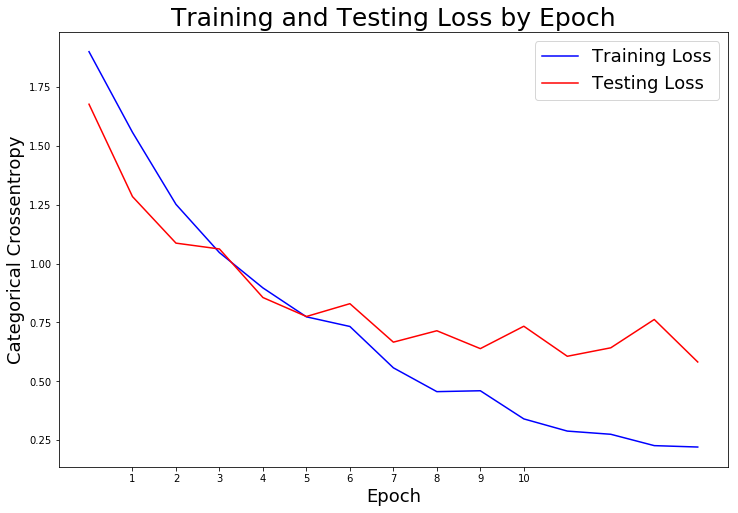

In [25]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,11), range(1,11))

plt.legend(fontsize = 18);

In [26]:
# Making predictions from the cnn model
predictions = cnn_model.predict(X_test, verbose=1)

140/140 [==============================] - 1s 4ms/sample


In [27]:
# Calculating the confusion matrix 
# row: actual
# columns: predicted
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[17,  0,  1,  0,  2,  0,  0],
       [ 0, 17,  0,  1,  0,  2,  0],
       [ 2,  1, 13,  0,  1,  1,  2],
       [ 0,  2,  0, 17,  0,  1,  0],
       [ 0,  0,  0,  0, 20,  0,  0],
       [ 0,  2,  1,  0,  1, 14,  2],
       [ 2,  0,  0,  0,  0,  2, 16]])

In [28]:
# Creating a dataframe of the confusion matrix with labels for readability 
confusion_df = pd.DataFrame(conf_matrix)
confusion_df

,0,1,2,3,4,5,6
0,17,0,1,0,2,0,0
1,0,17,0,1,0,2,0
2,2,1,13,0,1,1,2
3,0,2,0,17,0,1,0
4,0,0,0,0,20,0,0
5,0,2,1,0,1,14,2
6,2,0,0,0,0,2,16


In [29]:
# List of a subset of the genres
genre_labels = {
    0:'jazz',
    1:'hiphop',
    2:'country',
    3:'metal',
    4:'classical',
    5:'disco',
    6:'pop'
}

In [30]:
# Renaming rows and columns with labes
confusion_df = confusion_df.rename(columns=genre_labels)
confusion_df.index = confusion_df.columns
confusion_df

,jazz,hiphop,country,metal,classical,disco,pop
jazz,17,0,1,0,2,0,0
hiphop,0,17,0,1,0,2,0
country,2,1,13,0,1,1,2
metal,0,2,0,17,0,1,0
classical,0,0,0,0,20,0,0
disco,0,2,1,0,1,14,2
pop,2,0,0,0,0,2,16


## CNN 2

In [273]:
# List of a subset of the genres
genre_subset_2 = [
    'jazz',
    'reggae',
    'hiphop',
    'metal',
    'classical'
]

In [270]:
# Using our function to get our features and targets
X_train, X_test, y_train, y_test = preprocess_mel_spec_data(mel_specs, genre_subset_2)

In [275]:
# Initiating an empty neural network
cnn_model_2 = Sequential(name='cnn_2')

# Adding convolutional layer
cnn_model_2.add(Conv2D(filters=8,
                     kernel_size=(6,6),
                     padding='same',
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model_2.add(MaxPooling2D(pool_size=(20,20)))

# Adding convolutional layer
cnn_model_2.add(Conv2D(16,
                     kernel_size=(6,6),
                     padding='same',
                     activation='relu'))

# Adding max pooling layer
cnn_model_2.add(MaxPooling2D(pool_size=(2,2)))

# Adding a flattened layer to input our image data
cnn_model_2.add(Flatten())
              
# Adding a dense layer with 256 neurons
cnn_model_2.add(Dense(256, activation='relu'))

# Adding a dropout layer for regularization
cnn_model_2.add(Dropout(0.5))

# Adding a dense layer with 64 neurons
cnn_model_2.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model_2.add(Dropout(0.5))

# Adding an output layer
cnn_model_2.add(Dense(5, activation='softmax'))

# Compiling our neural network
cnn_model_2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model_2.fit(X_train,
                          y_train, 
                          batch_size=16,
                          validation_data=(X_test, y_test),
                          epochs=20)

Train on 375 samples, validate on 125 samples
Epoch 1/15
375/375 [==============================] - 6s 17ms/sample - loss: 1.6159 - accuracy: 0.1707 - val_loss: 1.5973 - val_accuracy: 0.1920
Epoch 2/15
375/375 [==============================] - 6s 15ms/sample - loss: 1.5868 - accuracy: 0.1760 - val_loss: 1.5793 - val_accuracy: 0.3680
Epoch 3/15
375/375 [==============================] - 6s 16ms/sample - loss: 1.5398 - accuracy: 0.2693 - val_loss: 1.6118 - val_accuracy: 0.2000
Epoch 4/15
375/375 [==============================] - 6s 16ms/sample - loss: 1.5976 - accuracy: 0.2107 - val_loss: 1.5150 - val_accuracy: 0.3200
Epoch 5/15
375/375 [==============================] - 6s 17ms/sample - loss: 1.4873 - accuracy: 0.3520 - val_loss: 1.3978 - val_accuracy: 0.5280
Epoch 6/15
375/375 [==============================] - 6s 16ms/sample - loss: 1.3230 - accuracy: 0.4427 - val_loss: 1.1736 - val_accuracy: 0.5360
Epoch 7/15
375/375 [==============================] - 6s 16ms/sample - loss: 1.1594 

In [276]:
# Checking the model summary
cnn_model_2.summary()

Model: "cnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 128, 660, 8)       296       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 6, 33, 8)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 6, 33, 16)         4624      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 3, 16, 16)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               196864    
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0     

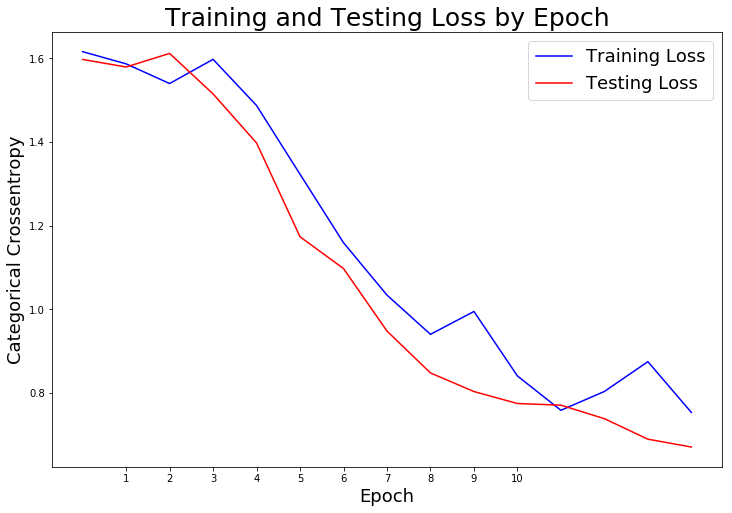

In [277]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,11), range(1,11))

plt.legend(fontsize = 18);

In [278]:
# Making predictions from the cnn model
predictions_2 = cnn_model_2.predict(X_test, verbose=1)

125/125 [==============================] - 0s 4ms/sample


In [279]:
# Calculating the confusion matrix 
# row: actual
# columns: predicted
conf_matrix_2 = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions_2, 1))
conf_matrix_2

array([[15,  1,  0,  0,  9],
       [ 2, 19,  2,  0,  2],
       [ 0, 10, 13,  2,  0],
       [ 2,  1,  3, 19,  0],
       [ 0,  0,  0,  0, 25]])

In [280]:
# Creating a dataframe of the confusion matrix with labels for readability 
confusion_df_2 = pd.DataFrame(conf_matrix_2)

In [281]:
# List of a subset of the genres
genre_labels_2 = {
    0:'jazz',
    1:'reggae',
    2:'rock',
    3:'hiphop',
    4:'metal',
    5:'classical'
}

In [282]:
# Renaming rows and columns with labes
confusion_df_2 = confusion_df_2.rename(columns=genre_labels_2)
confusion_df_2.index = confusion_df_2.columns
confusion_df_2

,jazz,reggae,rock,hiphop,metal
jazz,15,1,0,0,9
reggae,2,19,2,0,2
rock,0,10,13,2,0
hiphop,2,1,3,19,0
metal,0,0,0,0,25


In [32]:
7/25*100

28.000000000000004

In [33]:
7/13*100

53.84615384615385